In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:

# Load the training dataset
disease_training = pd.read_csv("../../../data/raw/Training.csv")

# Drop any unnecessary columns such as prognosis
predictors_training = disease_training.drop(columns=['prognosis'])
response_training = disease_training['prognosis']

    
# Drop any unwanted columns (e.g., unnamed columns)
if 'Unnamed: 133' in predictors_training.columns:
    predictors_training.drop(['Unnamed: 133'], axis=1, inplace=True)

symptoms = predictors_training.columns
symptoms

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'pus_filled_pimples', 'blackheads', 'scurring', 'skin_peeling',
       'silver_like_dusting', 'small_dents_in_nails', 'inflammatory_nails',
       'blister', 'red_sore_around_nose', 'yellow_crust_ooze'],
      dtype='object', length=132)

In [3]:
# Apply K-means clustering
num_clusters = 40  # Example, you can change the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(predictors_training)

# Add cluster labels to the original dataframe
disease_training['Cluster'] = kmeans.labels_

# View the assigned clusters
print(disease_training[['Cluster']])

      Cluster
0          23
1          23
2          23
3          23
4          23
...       ...
4915       38
4916       15
4917       33
4918       18
4919       30

[4920 rows x 1 columns]


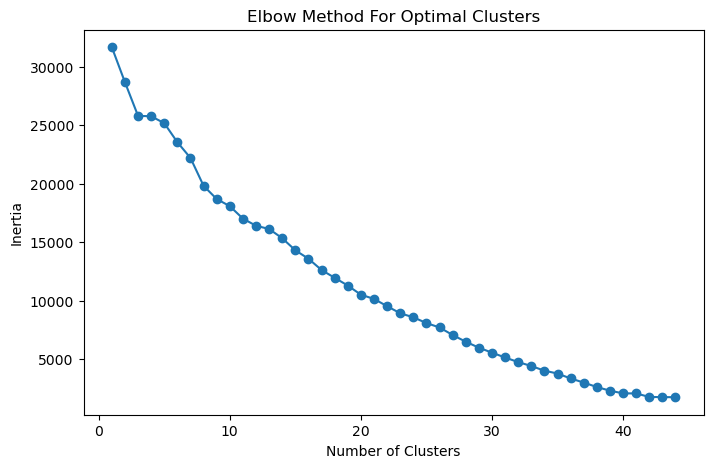

In [4]:
inertia_values = []
cluster_range = range(1, 45)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(predictors_training)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method For Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


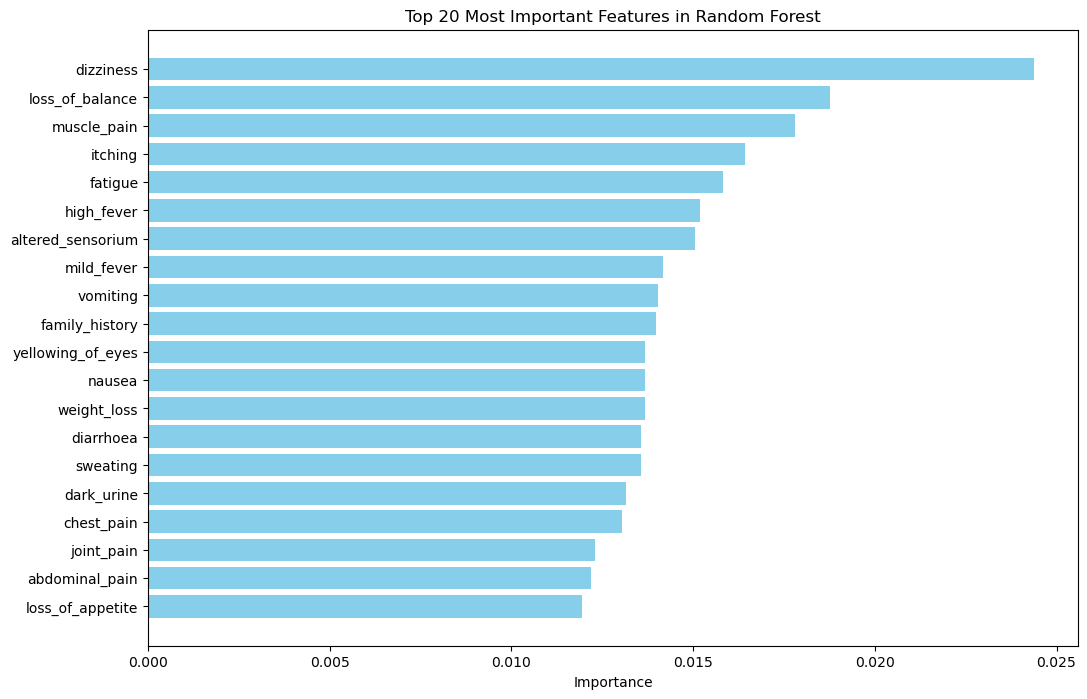

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Prepare the data
X = predictors_training
y = disease_training['Cluster']  # Cluster labels as target

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances_df['Feature'][:20], feature_importances_df['Importance'][:20], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()

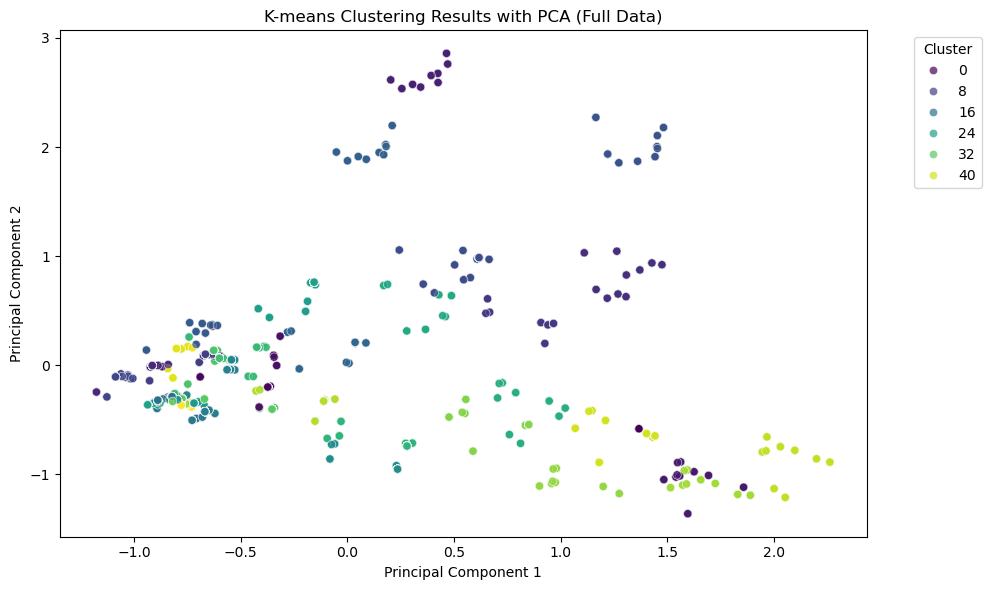

In [5]:
# Perform PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(predictors_training)

# Create a new DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Plot the clusters with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, alpha=0.7)
plt.title('K-means Clustering Results with PCA (Full Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
# Get the loadings (contribution of each symptom to each principal component)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=predictors_training.columns)

# Sort by absolute value of loadings in PC1 (or PC2) to find the most important symptoms
important_symptoms_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
important_symptoms_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)

# Print the most important symptoms for PC1 and PC2
print("Most important symptoms for PC1:")
print(important_symptoms_pc1)

print("\nMost important symptoms for PC2:")
print(important_symptoms_pc2)

Most important symptoms for PC1:
loss_of_appetite     0.374241
vomiting             0.317320
yellowing_of_eyes    0.312079
abdominal_pain       0.309484
nausea               0.299828
yellowish_skin       0.295244
fatigue              0.261818
dark_urine           0.232346
high_fever           0.209547
joint_pain           0.164557
Name: PC1, dtype: float64

Most important symptoms for PC2:
high_fever             0.323178
chills                 0.309027
malaise                0.284554
chest_pain             0.268637
cough                  0.267415
phlegm                 0.247098
fatigue                0.242966
yellowish_skin         0.231243
abdominal_pain         0.225627
swelled_lymph_nodes    0.202890
Name: PC2, dtype: float64


PCA takes the original data, which might have many dimensions (symptoms), and finds new axes (PC1, PC2, PC3, etc.) that are combinations of the original features (symptoms). These new axes are sorted based on how much variance they explain in the data.

Principal Component 1 (PC1): This is the direction in the data that captures the most variance, meaning it accounts for the largest spread of data points. It represents the most important feature combination that explains the differences between the samples.

Principal Component 2 (PC2): This is the second direction, capturing the second-largest amount of variance. PC2 is orthogonal (uncorrelated) to PC1, meaning it represents a different axis of variation in the data that PC1 does not capture.